In [1]:
import pandas as pd
import numpy as np

import csv   
import math
import matplotlib.pyplot as plt
import datetime

import librosa as lr
import librosa.display as lrd
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
SPLIT_TRAIN_TEST = .8
TARGET_FILE = '../data/guitar/guitar.csv'
SAMPLES_FOLDER = '../data/guitar/guitar_samples/'
FOLDER_PREFIX = 'guitar'

D = str(datetime.datetime.now())
RESULTS_FILE = 'RESULTS-' + FOLDER_PREFIX + '-' + D[:16].replace(' ','_') + '.csv'
print RESULTS_FILE

HOP_LENGTH = 512

N_MFCC = 20
N_MEL = 32

SUBSET = False
N_EPOCHS = 30
BATCH_SIZE = 32
VERBOSE = 1
VALIDATION = .1

DEPENDENCIES = {
    "delay_feedback"      : "delay_on_off",
    "delay_intensity"     : "delay_on_off",
    "delay_time"          : "delay_on_off",
    "disto_drive"         : "disto_on_off",
    "disto_tone"          : "disto_on_off",
    "filter_frequency"    : "filter_on_off",
    "filter_mode_LBF_HPF" : "filter_on_off",
    "filter_resonance"    : "filter_on_off",
    "flanger_intensity"   : "flanger_on_off",
    "flanger_mode"        : "flanger_on_off",
    "flanger_rate"        : "flanger_on_off",
    "flanger_width"       : "flanger_on_off",
    "reverb_bright"       : "reverb_on_off",
    "reverb_room_size"    : "reverb_on_off"
}

RESULTS-guitar-2018-01-16_14:04.csv


# Prepares datasets

In [3]:
# Prepares labels
Y = pd.read_csv(TARGET_FILE)
if SUBSET:
    Y = Y.head(100)
print Y.head()

len_train = int(Y.shape[0]*.8)
len_test = int(Y.shape[0]*.2)
print len_train, len_test

Y_train = Y.iloc[:len_train,:]
Y_test = Y.iloc[len_train:,:]
print 
print 'Training data:', Y_train.shape
print 'Test data:', Y_test.shape

Y_train, files_train =  Y_train.drop('file', axis=1), Y_train['file']
Y_test, files_test = Y_test.drop('file', axis=1), Y_test['file']
print
print files_train[:5]
print files_test[:5]

   flanger_intensity  delay_time  disto_drive  reverb_room_size reverb_on_off  \
0           0.629921    0.944882     2.755906          6.377953           off   
1           5.039370    4.645669     0.078740          4.803150           off   
2           2.440945    0.472441     6.692913          7.086614           off   
3           9.606299    2.283465     9.370079          7.086614           off   
4           7.007874    3.228346     9.921260          4.330709            on   

  delay_on_off  flanger_width  flanger_rate  disto_tone filter_on_off  \
0           on       1.496063      1.653543    7.165354           off   
1           on       9.763780      7.322835    4.960630           off   
2          off       5.275591      8.031496    0.314961            on   
3          off       6.929134      3.622047    7.165354            on   
4           on       7.480315      0.472441    5.984252           off   

   delay_feedback  delay_intensity flanger_on_off  reverb_bright  \
0     

In [4]:
# Loads waveforms
sampling_rate = lr.load(SAMPLES_FOLDER + files_train[0])[1]
print 'Sampling rate:', sampling_rate

waveforms_test = []
for i, file_name in enumerate(files_test):
    if i % 100 == 0:
        print 'Loaded testing waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_test.append(lr.load(f)[0])
X_test = np.stack(waveforms_test)
print X_test.shape


waveforms_train = []
for i, file_name in enumerate(files_train):
    if i % 100 == 0:
        print 'Loaded training waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_train.append(lr.load(f)[0])
X_train = np.stack(waveforms_train)
print X_train.shape

Sampling rate: 22050
Loaded testing waveform #0
Loaded testing waveform #100
Loaded testing waveform #200
Loaded testing waveform #300
Loaded testing waveform #400
Loaded testing waveform #500
Loaded testing waveform #600
Loaded testing waveform #700
Loaded testing waveform #800
Loaded testing waveform #900
Loaded testing waveform #1000
Loaded testing waveform #1100
Loaded testing waveform #1200
Loaded testing waveform #1300
Loaded testing waveform #1400
Loaded testing waveform #1500
Loaded testing waveform #1600
Loaded testing waveform #1700
Loaded testing waveform #1800
Loaded testing waveform #1900
(2000, 18522)
Loaded training waveform #0
Loaded training waveform #100
Loaded training waveform #200
Loaded training waveform #300
Loaded training waveform #400
Loaded training waveform #500
Loaded training waveform #600
Loaded training waveform #700
Loaded training waveform #800
Loaded training waveform #900
Loaded training waveform #1000
Loaded training waveform #1100
Loaded training w

# Independent models

## Prepares the features

In [5]:
L_test_mfcc = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_test_mfcc.append(mfcc)
X_test_mfcc = np.stack(L_test_mfcc)
print X_test_mfcc.shape

L_train_mfcc = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_train_mfcc.append(mfcc)
X_train_mfcc = np.stack(L_train_mfcc)
print X_train_mfcc.shape

(2000, 20, 37)
(8000, 20, 37)


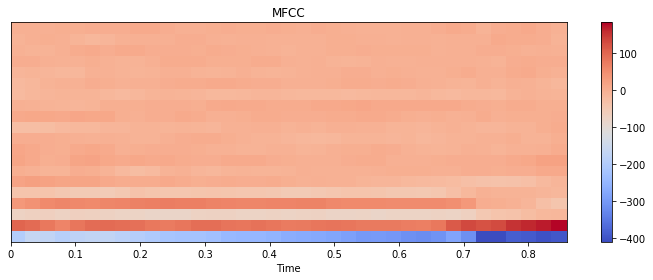

In [6]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mfcc[10,...], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [7]:
X_test_mfcc = np.reshape(X_test_mfcc, (X_test_mfcc.shape[0],-1))
X_train_mfcc = np.reshape(X_train_mfcc, (X_train_mfcc.shape[0],-1))
print X_test_mfcc.shape
print X_train_mfcc.shape

(2000, 740)
(8000, 740)


## Predictions

In [ ]:
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

headers=['algo', 'type', 'param1','param2','regularization',
         'target','metric', 'train_score', 'test_score']
with open(RESULTS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

    
def evaluate_algo(algo_label, grid_reg, grid_class):
    results = []
    for t_i, t_name in enumerate(list(Y_train)):

        print 'predicting feature', t_name
        y_train = Y_train[t_name]
        y_test = Y_test[t_name]
        print y_train.dtype
        
        if t_name in DEPENDENCIES:
            switch = DEPENDENCIES[t_name]
            
            to_keep_train = (Y_train[switch] == 'on')
            print 'Keeping', str(sum(to_keep_train)), 'training examples out of',  str(len(to_keep_train))
            y_train = y_train[to_keep_train]
            X_train= X_train_mfcc[to_keep_train,...]
            
            to_keep_test = (Y_test[switch] == 'on')
            print 'Keeping', str(sum(to_keep_test)), 'training examples out of',  str(len(to_keep_test))
            y_test = y_test[to_keep_test]
            X_test = X_test_mfcc[to_keep_test,...]
        
        else:
            X_train= X_train_mfcc
            X_test= X_test_mfcc
        
        print X_train.shape, y_train.shape
        print X_test.shape, y_test.shape
        
        best_params_C = None
        best_params_R = None
        
        try:
            # Case 1: classification
            if y_train.dtype == 'object':

                metric = 'class'

                # Cross-Validation Score
                grid_class.fit(X_train, y_train)
                cross_val_scores = grid_class.best_score_
                best_params_C = grid_class.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_class.predict(X_test)
                test_score = accuracy_score(test_pred, y_test)
                print test_score


            # Case 2: regression
            elif y_train.dtype == 'float64':

                metric = 'reg'

                # Cross-Validation Score
                grid_reg.fit(X_train, y_train)
                cross_val_scores = grid_reg.best_score_ * -1
                best_params_R = grid_reg.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_reg.predict(X_test)
                test_score = mean_absolute_error(test_pred, y_test)
                print test_score

            else:
                raise ValueError('Wrong Column Type')

            out = (algo_label, 'per_output', best_params_R, best_params_C,None,
                   t_name, metric, cross_val_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

        except:
            print "Unexpected error:", sys.exc_info()[0]

In [ ]:
from sklearn import neighbors

algo_C =neighbors.KNeighborsClassifier()
grid_C = GridSearchCV(algo_C, {"n_neighbors":[3,5,8,16]}, scoring='accuracy', verbose=2)

algo_R =neighbors.KNeighborsRegressor()
grid_R = GridSearchCV(algo_R, {"n_neighbors":[3,5,8,16]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('kNN', grid_R, grid_C)

In [ ]:
from sklearn import tree

algo_C = tree.DecisionTreeClassifier()
grid_C = GridSearchCV(algo_C, {"max_depth":[2,4,8,16,32,64,128]}, scoring='accuracy', verbose=2)

algo_R = tree.DecisionTreeRegressor()
grid_R = GridSearchCV(algo_R, {"max_depth":[2,4,8,16,32,64,128]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Decision Tree', grid_R, grid_C)

In [ ]:
from sklearn import dummy

algo_C = dummy.DummyClassifier()
grid_C = GridSearchCV(algo_C, {"strategy":["most_frequent"]}, scoring='accuracy', verbose=2)

algo_R = dummy.DummyRegressor()
grid_R = GridSearchCV(algo_R, {"strategy":["mean"]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Naive', grid_R, grid_C)

In [ ]:
# from sklearn import svm

# algo_R = svm.SVR(kernel='linear')
# grid_R = GridSearchCV(algo_R, {'C':[.01, .1, 1.]},
#                       scoring='neg_mean_absolute_error', verbose=2,
#                      n_jobs =4)

# algo_C = svm.SVC(kernel='linear')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1.]},
#                       scoring='accuracy', verbose=2,
#                       n_jobs =4)


# evaluate_algo('SVM_lin', grid_R, grid_C)

# algo_R = svm.SVR(kernel='RBF')
# grid_R = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='neg_mean_absolute_error', verbose=2)

# algo_C = svm.SVC(kernel='RBF')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='accuracy', verbose=2)


# evaluate_algo('SVM_RBF', grid_R, grid_C)

# Joint modelling

In [8]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

flanger_intensity
delay_time
disto_drive
reverb_room_size
reverb_on_off
delay_on_off
flanger_width
flanger_rate
disto_tone
filter_on_off
delay_feedback
delay_intensity
flanger_on_off
reverb_bright
filter_resonance
flanger_mode
disto_on_off
filter_mode_LBF_HPF
filter_frequency
OrderedDict([('flanger_intensity', {'sd': 2.9184593957810758, 'type': dtype('float64'), 'mean': 5.0211220472442726}), ('delay_time', {'sd': 1.4628781135915525, 'type': dtype('float64'), 'mean': 2.4919685039374326}), ('disto_drive', {'sd': 2.9100526207312742, 'type': dtype('float64'), 'mean': 4.9850590551182776}), ('reverb_room_size', {'sd': 2.8795422398846529, 'type': dtype('float64'), 'mean': 4.9572539370080726}), ('reverb_on_off', {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}), ('delay_on_off', {'char2int': {'on': 1, 'off': 0}, 'int2char': {0: 'off', 1: 'on'}, 'type': dtype('O')}), ('flanger_width', {'sd': 2.9026383540878467, 'type': dtype('float64'), 'mean': 4.9900885826

In [9]:
# Preps input data
X_train_mfcc = X_train_mfcc.reshape([X_train_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)
X_test_mfcc = X_test_mfcc.reshape([X_test_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)

print ''
print X_train_mfcc.shape
print X_test_mfcc.shape


(8000, 37, 20)
(2000, 37, 20)


In [10]:
from keras.callbacks import EarlyStopping

def format_output(Y):
    out = {}
    for name,infos in Y_info.iteritems():

        # Normalizes/one-hot encodes
        if infos['type'] == 'float64':
            y = (Y[name] - infos['mean']) / infos['sd']
            
        elif infos['type'] == 'object':
            char2int = infos['char2int']
            y = np.zeros((len(Y[name]), len(char2int)))
            for i,yval in enumerate(Y[name]):
                y[i, char2int[yval]] = 1        
        else:
            raise ValueError
        
        # Sets to zero if necessary
        if name in DEPENDENCIES:
            switch = DEPENDENCIES[name]
            is_off = Y[switch] == "off"
            print 'Setting', str(sum(is_off)),'elements to zero'
            y[is_off] = 0
        
        print name, y.shape
        out[name] = y
    
    return out

        
def test_model(label, params1, params2, regul, model, X_train, X_test):
    
    try:
        # Prepares input and output data
        X_mean = np.mean(X_train, axis=(0))
        X_sd = np.std(X_train, axis=(0))

        X_train = (X_train - X_mean) / X_sd
        X_test  = (X_test - X_mean) / X_sd

        Y_dict_train = format_output(Y_train)
        Y_dict_test  = format_output(Y_test)

        # Trains the model
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        hist = model.fit(X_train, Y_dict_train, 
                  epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
                 validation_split = VALIDATION, callbacks=[early_stopping])

        # Makes predictions
        pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)

        # Gets validation and test scores (for each metric)
        Y = {}
        for j, Y_pred in enumerate(pred):
            print 'Output:', j
            t_name = Y_info.keys()[j]
            t_infos = Y_info[t_name]
            truth = Y_test[t_name]
            print t_name
            print Y_pred.shape

            if t_name in DEPENDENCIES:
                switch = DEPENDENCIES[t_name]

                to_keep_test = (Y_test[switch] == 'on')
                print 'Keeping', str(sum(to_keep_test)), 'training examples out of',  str(len(to_keep_test))
                truth = truth[to_keep_test]
                Y_pred = Y_pred[to_keep_test,...]
                print Y_pred.shape, truth.shape

            if t_infos['type'] == 'float64':
                test_metric = 'reg'
                Y_pred = Y_pred.flatten()
                y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
                y_pred = y_pred.tolist()
                test_score = mean_absolute_error(y_pred, truth)

            elif t_infos['type'] == 'object':
                test_metric = 'class'
                y_i = np.argmax(Y_pred, axis=1)
                y_pred = [t_infos['int2char'][y] for y in y_i]
                test_score = accuracy_score(y_pred, truth)

            else:
                raise ValueError

            train_scores = -1 * hist.history['val_loss'][-1]
            out = (label, 'joint', params1, params2, regul,
                   t_name, test_metric, train_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

            Y[t_name] = y_pred
            
    except:
        print "Unexpected error:", sys.exc_info()[0]
        return
    
    return Y

Using TensorFlow backend.


In [11]:
def NN_output(h_layer):
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    
    # Adds on/off switches
    switches = []
    for name,infos in Y_info.iteritems():
        if not name in DEPENDENCIES and infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'
            switches.append(name)
            out_layers.append(out_layer)
            
        if not name in DEPENDENCIES and infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            switches.append(name)
            out_layers.append(out_layer)
            
    # Adds dependent switches and knobs
    dependent = []
    for name,infos in Y_info.iteritems():
        
        if name in DEPENDENCIES and infos['type'] == 'float64':
            pred_layer = Dense(1)(h_layer)
            
            switch = DEPENDENCIES[name]
            li_switch = switches.index(switch)
            i_on = Y_info[switch]['char2int']['on']
            switch = Lambda(lambda T: T[:,i_on])(out_layers[li_switch])
            out_layer = Multiply(name = name)([pred_layer, switch])
            
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            out_layers.append(out_layer)
            dependent.append(name)

        
        if name in DEPENDENCIES and infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            pred_layer = Dense(out_dim, activation='softmax')(h_layer)            
            
            switch = DEPENDENCIES[name]
            li_switch = switches.index(switch)
            i_on = Y_info[switch]['char2int']['on']
            switch = Lambda(lambda T: T[:,i_on])(out_layers[li_switch])
            out_layer = Multiply(name = name)([pred_layer, switch])
            
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'
            out_layers.append(out_layer)
            dependent.append(name)
        
    # Reorders everything
    all_out = switches + dependent
    ord_out = []
    for out_name in Y_info:
        o = out_layers[all_out.index(out_name)]
        ord_out.append(o)

    return ord_out, metrics, losses

In [ ]:
# Model 1: 1 layer perceptron
from keras.layers import Input, Dense, Flatten, Multiply, Lambda, RepeatVector
from keras import backend as K
from keras.models import Model
from keras import regularizers

def MLP(n_hidden_units, n_layers, regul, in_shape):
    # Input layer
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = Flatten()(in_layer)
    for i in range(n_layers):
        h_layer = Dense(n_hidden_units, activation='relu')(h_layer)

    out_layers, metrics, losses = NN_output(h_layer)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [64,90,128]:
        for REGUL in [0]:
            in_dim = X_train_mfcc.shape[1:]
            model = MLP(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('MLP', N_UNITS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

In [14]:
from keras.layers import LSTM
from keras.layers import Input, Dense, Flatten, Multiply, Lambda, RepeatVector
from keras import backend as K
from keras.models import Model
from keras import regularizers

def modLSTM(n_hidden_units, n_layers, regul, in_shape):
    # Input layer
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        seq = i < n_layers - 1
        h_layer = LSTM(n_hidden_units, return_sequences=seq, dropout=regul)(h_layer)
        
    # Output layers and losses
    out_layers, metrics, losses = NN_output(h_layer)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [32,64,80,128]:
        for REGUL in [0,0.2]:
            in_dim = X_train_mfcc.shape[1:]
            model = modLSTM(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('LSTM', N_UNITS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 37, 20)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           6784        input_1[0][0]                    
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            66          lstm_1[0][0]                     
__________________________________________________________________________________________________
delay_on_off (Dense)            (None, 2)            66          lstm_1[0][0]                     
__________________________________________________________________________________________________
disto_on_o

Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_drive (2000,)
Setting 997 elements to zero
reverb_room_size (2000,)
reverb_on_off (2000, 2)
delay_on_off 

NameError: global name 'sys' is not defined

In [ ]:
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

W = 4

def modConvo(n_filters, n_layers, regul, in_shape):
    # Input layer
    print in_shape
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        print i
        conv_layer = Conv1D(n_filters*(i+1), W, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        h_layer = MaxPooling1D(W, strides=2)(conv_layer)
    
    h_layer_pool = GlobalMaxPooling1D()(h_layer)
    h_layer_full = Dense(n_filters, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer_pool)
    
    # Output layers and losses
    out_layers, metrics, losses = NN_output(h_layer_full)
    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_FILTERS in [16,32,48,64]:
    for N_LAYERS in [1,2]:
        for REGUL in [0]:
            in_dim = X_train_mfcc.shape[1:]
            model = modConvo(N_FILTERS, N_LAYERS, REGUL, in_dim)
            out = test_model('Conv', N_FILTERS, N_LAYERS, REGUL, model, X_train_mfcc, X_test_mfcc)

# Mid level features

In [ ]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

In [ ]:
L_test_mel = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_test_mel.append(mel)
X_test_mel = np.stack(L_test_mel)
print X_test_mel.shape

L_train_mel = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_train_mel.append(mel)
X_train_mel = np.stack(L_train_mel)
print X_train_mel.shape

In [ ]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mel[2,...], x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')
plt.tight_layout()

In [ ]:
X_train_mel = np.transpose(X_train_mel, (0,2,1))
X_test_mel = np.transpose(X_test_mel, (0,2,1))
print X_train_mel.shape, X_test_mel.shape

In [ ]:
for N_LAYERS in [1,2]:
    for N_UNITS in [64,90,128]:
        for REGUL in [0]:
            in_dim = X_train_mel.shape[1:]
            model = MLP(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('MLP_mid', N_UNITS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

In [ ]:
for N_LAYERS in [1,2]:
    for N_UNITS in [32,64,80,128]:
        for REGUL in [0,0.2]:
            in_dim = X_train_mel.shape[1:]
            model = modLSTM(N_UNITS, N_LAYERS, REGUL, in_dim)
            out = test_model('LSTM_mid', N_UNITS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

In [ ]:
for N_FILTERS in [16,32,48,64]:
    for N_LAYERS in [1,2]:
        for REGUL in [0]:
            in_dim = X_train_mel.shape[1:]
            model = modConvo(N_FILTERS, N_LAYERS, REGUL, in_dim)
            out = test_model('Conv_mid', N_FILTERS, N_LAYERS, REGUL, model, X_train_mel, X_test_mel)

# Visualizing the results

In [ ]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)

# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score)) +
    geom_bar(stat='identity') +
    facet_grid(metric~., scales='free')
p


In [ ]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)


# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
to_plot$family <- sapply(to_plot$algo,function(n){
    if (n%in%c('Conv', "LSTM", "MLP")){
        "joint model + MFCC"
    } else if (n%in%c('Conv_mid', "LSTM_mid", "MLP_mid")){
        "joint model + Mel Spectrum"
    } else{
        "Independent + MFCC"
    }
})

print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score, color=family, fill=family)) +
    geom_bar(stat='identity') +
    facet_grid(metric~family, scales='free')
p

ggsave('results_guitar.pdf', p, width=10)

In [19]:
def show_model(model, X_train, X_test):
    
    try:
        # Prepares input and output data
        X_mean = np.mean(X_train, axis=(0))
        X_sd = np.std(X_train, axis=(0))

        X_train = (X_train - X_mean) / X_sd
        X_test  = (X_test - X_mean) / X_sd

        Y_dict_train = format_output(Y_train)
        Y_dict_test  = format_output(Y_test)

        # Trains the model
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        hist = model.fit(X_train, Y_dict_train, 
                  epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
                 validation_split = VALIDATION, callbacks=[early_stopping])

        # Makes predictions
        pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)

        # Gets validation and test scores (for each metric)
        Y = {}
        for j, Y_pred in enumerate(pred):
            t_name = Y_info.keys()[j]
            t_infos = Y_info[t_name]
            truth = Y_test[t_name]
            print t_name

            if t_infos['type'] == 'float64':
                test_metric = 'reg'
                Y_pred = Y_pred.flatten()
                y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
                y_pred = y_pred.tolist()

            elif t_infos['type'] == 'object':
                test_metric = 'class'
                y_i = np.argmax(Y_pred, axis=1)
                y_pred = [t_infos['int2char'][y] for y in y_i]

            else:
                raise ValueError


            Y[t_name] = (y_pred, truth)
            
    except:
        print "Unexpected error:", sys.exc_info()[0]
        return
    
    return Y





in_dim = X_train_mfcc.shape[1:]
model = modLSTM(128, 2, 0, in_dim)
out = show_model(model, X_train_mfcc, X_test_mfcc)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 37, 20)       0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 37, 128)      76288       input_5[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 128)          131584      lstm_8[0][0]                     
__________________________________________________________________________________________________
flanger_on_off (Dense)          (None, 2)            258         lstm_9[0][0]                     
__________________________________________________________________________________________________
delay_on_o

Setting 3972 elements to zero
flanger_intensity (8000,)
Setting 4014 elements to zero
delay_time (8000,)
Setting 4068 elements to zero
disto_drive (8000,)
Setting 3990 elements to zero
reverb_room_size (8000,)
reverb_on_off (8000, 2)
delay_on_off (8000, 2)
Setting 3972 elements to zero
flanger_width (8000,)
Setting 3972 elements to zero
flanger_rate (8000,)
Setting 4068 elements to zero
disto_tone (8000,)
filter_on_off (8000, 2)
Setting 4014 elements to zero
delay_feedback (8000,)
Setting 4014 elements to zero
delay_intensity (8000,)
flanger_on_off (8000, 2)
Setting 3990 elements to zero
reverb_bright (8000,)
Setting 3940 elements to zero
filter_resonance (8000,)
Setting 3972 elements to zero
flanger_mode (8000, 3)
disto_on_off (8000, 2)
Setting 3940 elements to zero
filter_mode_LBF_HPF (8000,)
Setting 3940 elements to zero
filter_frequency (8000,)
Setting 981 elements to zero
flanger_intensity (2000,)
Setting 1013 elements to zero
delay_time (2000,)
Setting 989 elements to zero
disto_

Epoch 6/30
7200/7200 [==============================] - 25s 3ms/step - loss: 4.1443 - flanger_intensity_loss: 0.3448 - delay_time_loss: 0.1898 - disto_drive_loss: 0.3683 - reverb_room_size_loss: 0.2462 - reverb_on_off_loss: 0.0321 - delay_on_off_loss: 0.0473 - flanger_width_loss: 0.3089 - flanger_rate_loss: 0.3744 - disto_tone_loss: 0.1483 - filter_on_off_loss: 0.0518 - delay_feedback_loss: 0.2920 - delay_intensity_loss: 0.3195 - flanger_on_off_loss: 0.1854 - reverb_bright_loss: 0.4310 - filter_resonance_loss: 0.2311 - flanger_mode_loss: 0.2109 - disto_on_off_loss: 0.0339 - filter_mode_LBF_HPF_loss: 0.1590 - filter_frequency_loss: 0.1697 - val_loss: 4.6711 - val_flanger_intensity_loss: 0.3729 - val_delay_time_loss: 0.2114 - val_disto_drive_loss: 0.3569 - val_reverb_room_size_loss: 0.2790 - val_reverb_on_off_loss: 0.0405 - val_delay_on_off_loss: 0.0905 - val_flanger_width_loss: 0.3487 - val_flanger_rate_loss: 0.4091 - val_disto_tone_loss: 0.1529 - val_filter_on_off_loss: 0.0865 - val_de

7200/7200 [==============================] - 26s 4ms/step - loss: 3.3894 - flanger_intensity_loss: 0.2902 - delay_time_loss: 0.1501 - disto_drive_loss: 0.3067 - reverb_room_size_loss: 0.2023 - reverb_on_off_loss: 0.0141 - delay_on_off_loss: 0.0242 - flanger_width_loss: 0.2793 - flanger_rate_loss: 0.3420 - disto_tone_loss: 0.1193 - filter_on_off_loss: 0.0238 - delay_feedback_loss: 0.2452 - delay_intensity_loss: 0.2726 - flanger_on_off_loss: 0.1293 - reverb_bright_loss: 0.4080 - filter_resonance_loss: 0.1831 - flanger_mode_loss: 0.1280 - disto_on_off_loss: 0.0218 - filter_mode_LBF_HPF_loss: 0.1223 - filter_frequency_loss: 0.1271 - val_loss: 4.4138 - val_flanger_intensity_loss: 0.3522 - val_delay_time_loss: 0.1885 - val_disto_drive_loss: 0.3600 - val_reverb_room_size_loss: 0.2697 - val_reverb_on_off_loss: 0.0371 - val_delay_on_off_loss: 0.0741 - val_flanger_width_loss: 0.3567 - val_flanger_rate_loss: 0.3980 - val_disto_tone_loss: 0.1430 - val_filter_on_off_loss: 0.0861 - val_delay_feedbac

In [26]:
df_truth = {}
df_pred = {}

for attr,(pred,truth) in out.iteritems():
    print attr
    df_pred[attr] = pred[:15]
    df_truth[attr] = truth[:15]
    
df_truth = pd.DataFrame(df_truth)
df_pred = pd.DataFrame(df_pred)

print(df_pred)
df_pred.to_csv('~/Desktop/pred.csv', index=False)
df_truth.to_csv('~/Desktop/truth.csv', index=False)

flanger_intensity
delay_feedback
disto_drive
reverb_room_size
reverb_on_off
delay_on_off
flanger_width
flanger_rate
filter_frequency
disto_tone
filter_on_off
delay_intensity
flanger_on_off
reverb_bright
filter_resonance
delay_time
disto_on_off
filter_mode_LBF_HPF
flanger_mode
    delay_feedback  delay_intensity delay_on_off  delay_time  disto_drive  \
0         7.136765         3.816632           on    2.008607     6.049571   
1         4.834141         5.974379           on    3.624731     3.394115   
2         5.037433         4.987900          off    2.491492     5.008892   
3         5.037750         4.987683          off    2.491816     3.511158   
4         2.033757         3.451256           on    4.629666     2.482269   
5         3.139512         6.068203           on    3.493266     4.991957   
6         5.037594         4.986743          off    2.491649     2.348715   
7         5.037423         4.984441          off    2.490179     3.248322   
8         4.594501         3.4